### (1) sets up the **1D free Dirac equation** in the Hamiltonian form
$i\frac{\partial}{\partial t}\Psi(x,t) = H\Psi(x,t),\qquad H = -i\alpha\partial_x + m\beta,$

with the $(2\times2)$ Dirac matrices $(\alpha=\sigma_x,\ \beta=\sigma_z)$; 

## (2) builds a Gaussian spinor wavepacket; and 

## (3) shows a plot of the probability density $(\rho(x,t)=\Psi^\dagger\Psi)$ at $(t=0)$ and at some later time.



In [1]:
using LinearAlgebra
using SparseArrays
using Plots

[ Info: Diagonalizing H (size 802 × 802) ...


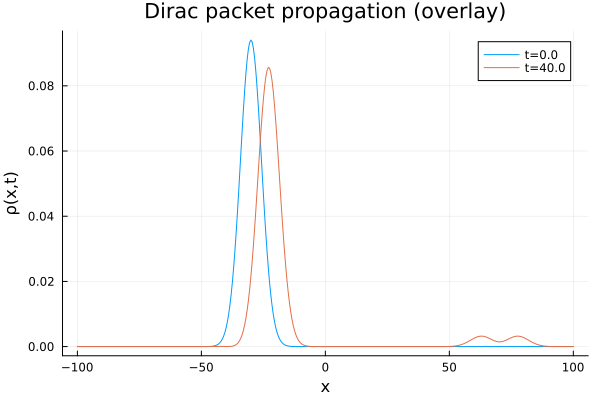

[ Info: Saved overlay plot to images/dirac_density_overlay.png


In [2]:
# dirac1d.jl

# ---- Parameters ----
N = 401                # spatial grid points (odd recommended)
L = 200.0              # domain length
x = range(-L/2, L/2, length=N)
dx = x[2] - x[1]
m = 1.0                # mass (in natural units: ħ = c = 1)

# Times to plot
times = [0.0, 40.0]    # you can add more times, e.g., [0.0, 10.0, 20.0, 40.0]

# ---- Dirac matrices (1+1D Hamiltonian representation) ----
α = [0.0 1.0; 1.0 0.0]    # sigma_x
β = [1.0 0.0; 0.0 -1.0]   # sigma_z
Ispin = Matrix{Float64}(I,2,2)

# ---- Spatial derivative operator (central difference) ----
# D approximates ∂/∂x with second-order central difference
e = ones(N)
offset = 1/(2dx)
data = [-offset*e[1:end-1], zeros(N), offset*e[1:end-1]]
D = spdiagm(-1 => data[1], 0 => data[2], 1 => data[3])
# For Neumann-like boundaries we leave first/last row as zeros (approx free BC).
# (Optionally use periodic BC by filling corners.)

# ---- Build full Hamiltonian H = -i α ⊗ D + m β ⊗ I_N  ----
# We'll assemble H as a 2N x 2N sparse matrix using Kronecker products
Ntot = 2 * N
H = spzeros(ComplexF64, Ntot, Ntot)

# m * β ⊗ I_N
H += kron(β, spdiagm(0 => ones(N))) * m

# -i * α ⊗ D
H += kron(α, -im * D)

# Convert to dense for eigen decomposition (OK for moderate N)
Hmat = Matrix(H)

# ---- Eigen-decompose H for time evolution operator exp(-i H t) ----
# Diagonalize (for larger N use expv Krylov methods instead)
@info "Diagonalizing H (size $(size(Hmat,1)) × $(size(Hmat,2))) ..."
eig = eigen(Hmat)   # returns eigenvalues and eigenvectors
Evals = eig.values
Evecs = eig.vectors

# ---- Initial spinor: Gaussian wavepacket on the "upper" spin component ----
x0 = -30.0            # initial center
p0 = 0.8              # central momentum
sigma = 6.0           # width of packet

# Spinor initial guess: put Gaussian in positive-energy-like combination.
# Construct scalar Gaussian envelope
ψ0_scalar = @. exp(-0.5*((x .- x0)/sigma)^2) * exp(im * p0 * x)
# Choose spinor direction (simple choice: mostly upper component)
spinor_dir = [1.0; 0.0]

# build full 2N vector: interleave spin components for each x
ψ0 = zeros(ComplexF64, Ntot)
for j in 1:N
    ψ0[2*(j-1)+1] = ψ0_scalar[j] * spinor_dir[1]   # upper
    ψ0[2*(j-1)+2] = ψ0_scalar[j] * spinor_dir[2]   # lower
end

# normalize initial spinor
norm0 = sqrt(sum(abs2, ψ0) * dx)
ψ0 ./= norm0

# ---- Function to get psi(t) via diagonalization ----
function psi_at_t(t)
    phases = exp.(-im * Evals * t)
    return Evecs * (phases .* (Evecs' * ψ0))
end

# ---- Compute densities at requested times ----
densities = []
for t in times
    ψt = psi_at_t(t)
    # compute probability density ρ(x) = ψ†ψ at each spatial point
    ρ = zeros(Float64, N)
    for j in 1:N
        up = ψt[2*(j-1)+1]
        dn = ψt[2*(j-1)+2]
        ρ[j] = real(abs2(up) + abs2(dn))
    end
    push!(densities, ρ)
end

# ---- Plotting ----
plot_layout = (length(times), 1)
p = plot(size=(800,300*length(times)), legend=false)
for (i,t) in enumerate(times)
    plt = plot(x, densities[i],
        xlabel="x", ylabel="Probability density",
        title = "Dirac wavepacket density at t = $(t)",
        ylim=(0, maximum(densities[1])*1.5))
    plot!(plt)
    if i==1
        p = plt
    else
        p = plot(p, plt, layout = (i,1))
    end
end

# If you want a single figure with both curves overlaid:
p2 = plot(x, densities[1], label="t=$(times[1])", xlabel="x", ylabel="ρ(x,t)",
          title="Dirac packet propagation (overlay)")
plot!(x, densities[end], label="t=$(times[end])")
display(p2)

# Save plots
savefig(p2, "images/dirac_density_overlay.png")
@info "Saved overlay plot to images/dirac_density_overlay.png"


### Notes & tips

* This uses the simple 1D Hamiltonian $(H=-i\alpha\partial_x + m\beta)$ with $(\alpha=\sigma_x), (\beta=\sigma_z)$. That Hamiltonian is commonly used for pedagogical 1-D Dirac wavepacket demos.
* The code diagonalizes the full Hamiltonian and computes $(\Psi(x,t)=e^{-iHt}\Psi(x,0))$ by applying the phases to eigenmodes. This is simple and accurate but scales as $(O((2N)^3))$ for diagonalization; for large (N) use Krylov/expv methods instead.
* Boundary conditions here are effectively open/free at the ends (derivative rows were left zero). You can switch to periodic BC by filling the corner entries of `D`.
* Units: we set $(\hbar=c=1)$. Change `m`, `p0`, `sigma` to explore relativistic vs nonrelativistic regimes.
* To see more time snapshots, add more entries to `times` (but note diagonalization is done once; evaluating psi_at_t is cheap after that).



In [3]:
using GLMakie

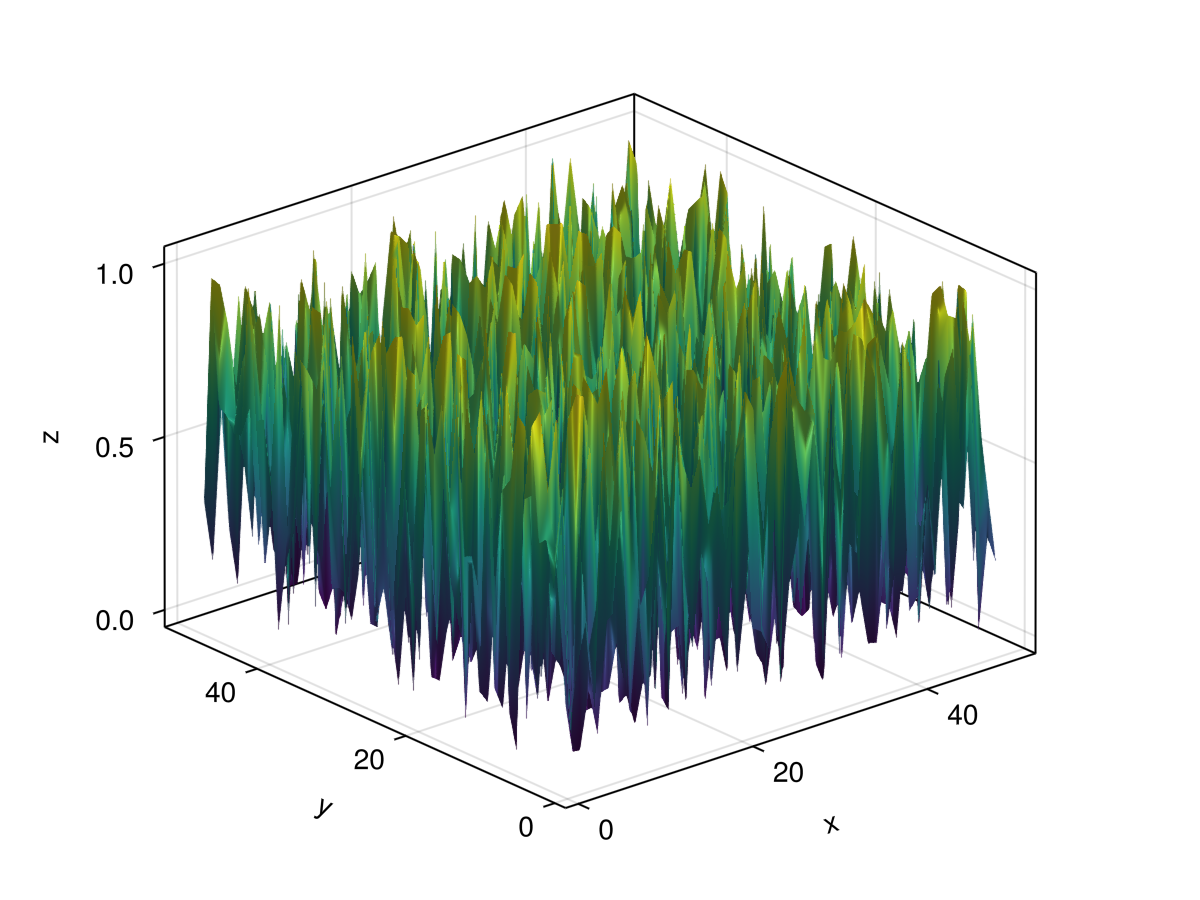

In [4]:
fig = Figure()
ax = Axis3(fig[1,1])
GLMakie.surface!(ax, rand(50,50))
fig


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/FUAHr/src/scenes.jl:238


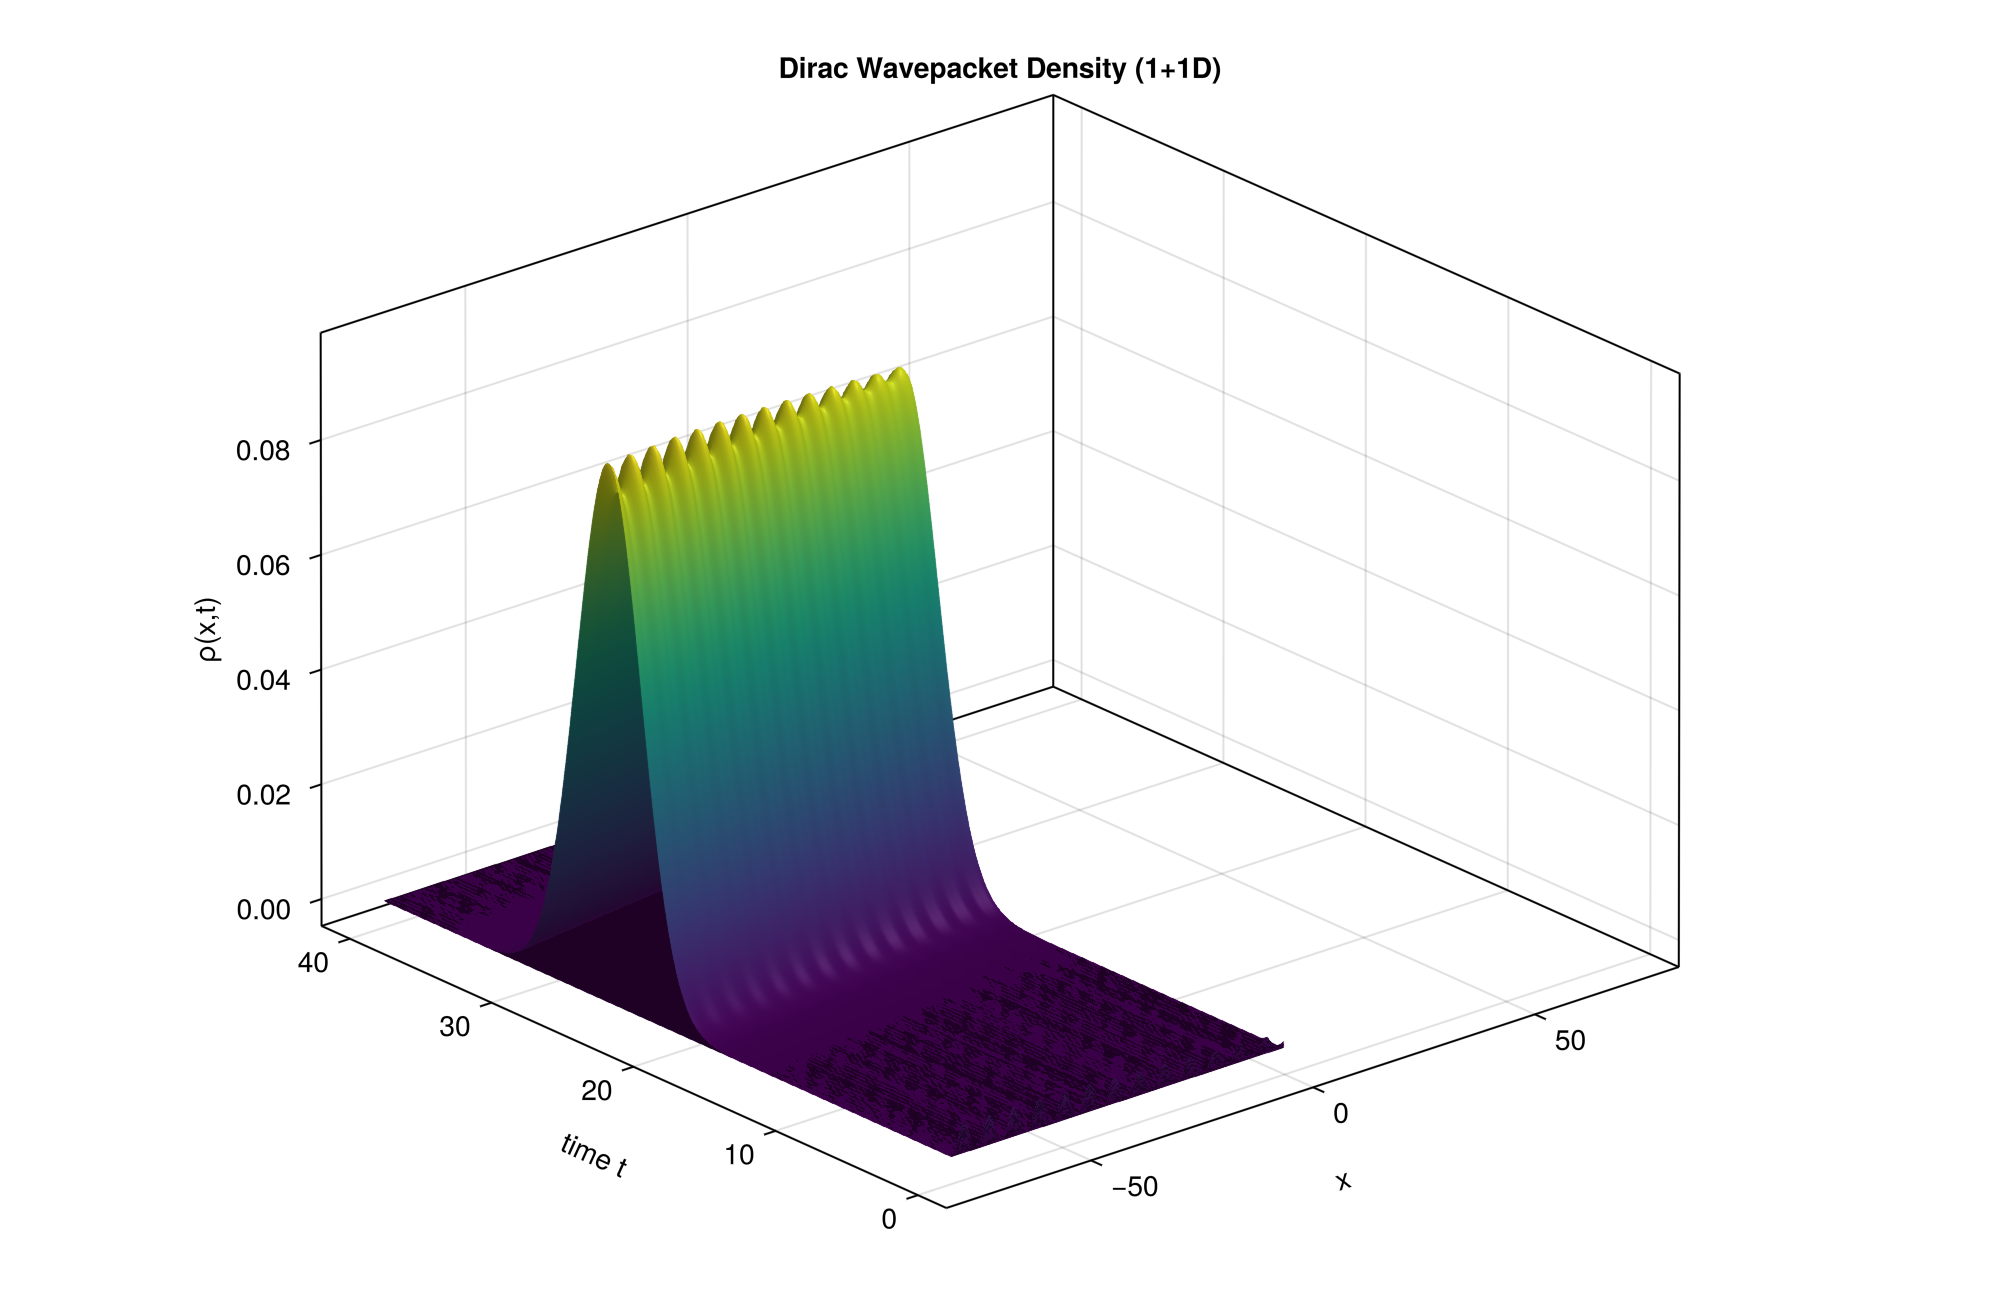

In [5]:
# =========================================================
# 1. Dirac Equation Setup (1+1 dimensional)
# =========================================================

# Spatial grid
N  = 300
L  = 150.0
x  = range(-L/2, L/2, length=N)
dx = x[2] - x[1]

# Dirac matrices (Pauli-like in 1D)
α = [0 1; 1 0]
β = [1 0; 0 -1]

m = 1.0   # mass

# Derivative operator (sparse)
offset = 1 / (2dx)
D = spdiagm(-1 => -offset .* ones(N-1), 
             1 =>  offset .* ones(N-1))

# Hamiltonian: H = -i α ⊗ D + m β ⊗ I
H = kron(β, I(N)) * m + kron(α, -1im .* D)
Hmat = Matrix(H)

# =========================================================
# 2. Solve eigenproblem for time evolution
# =========================================================
eig = eigen(Hmat)
E = eig.values
V = eig.vectors

# =========================================================
# 3. Initial wavepacket (Gaussian spin-up)
# =========================================================
x0 = -30
p0 = 0.5
σ  = 6.0

ψ0_scalar = @. exp(-(x - x0)^2/(2σ^2)) * exp(im*p0*x)

ψ0 = zeros(ComplexF64, 2N)
for j in 1:N
    ψ0[2j-1] = ψ0_scalar[j]
    ψ0[2j]   = 0
end

ψ0 ./= sqrt(sum(abs2, ψ0) * dx)  # normalize

# time evolution via eigenbasis
ψ_at_t(t) = V * (exp.(-im .* E .* t) .* (V' * ψ0))

# =========================================================
# 4. Compute density ρ(x, t)
# =========================================================
T = range(0, 40, length=150)
ρ = zeros(length(T), N)

for (i, t) in enumerate(T)
    ψt = ψ_at_t(t)
    for j in 1:N
        up = ψt[2j-1]
        dn = ψt[2j]
        ρ[i,j] = abs2(up) + abs2(dn)
    end
end

# =========================================================
# 5. 3D Surface Plot with GLMakie
# =========================================================
fig = Figure(resolution = (1000, 650))
ax = Axis3(fig[1,1],
    xlabel = "x",
    ylabel = "time t",
    zlabel = "ρ(x,t)",
    title = "Dirac Wavepacket Density (1+1D)"
)

# Makie expects row-major matching
GLMakie.surface!(ax, x, T, ρ)

fig


# Dirac

Below is a clear explanation of how to **write and solve the Dirac equation as a differential equation in Julia**, including the mathematics and how it looks in code.

---

# 📌 **1. The Dirac Equation (in natural units ℏ = c = 1)**

$$
i\frac{\partial \psi}{\partial t}
= \left( -i \boldsymbol{\alpha}\cdot \nabla + \beta m \right)\psi
$$

Where

* $(\psi(\mathbf{x},t))$ is a **4-component complex spinor**,
* $(\alpha_i)$ and $(\beta)$ are **4×4 Dirac matrices**,
* $(m)$ is the mass.

This is a **first-order linear PDE**.

---

# 📌 **2. Turning the Dirac Equation Into an ODE System**

To use Julia’s `DifferentialEquations.jl`, we convert the PDE into **finite-difference space + ODE time**.

Steps:

### **(A) Spatial discretization**

Let the 1D grid be:



In [6]:
x = range(-L, L, length=N)
Δx = step(x)


1.0033444816053512

Approximate spatial derivatives using central finite differences:

$$
\partial_x \psi_j \approx \frac{\psi_{j+1} - \psi_{j-1}}{2\Delta x}
$$

### **(B) Time evolution ODE**

For each grid point (j):

$$
\frac{d\psi_j}{dt} = -\alpha_x \frac{\psi_{j+1}-\psi_{j-1}}{2\Delta x} - i \beta m \psi_j
$$

This is a **large ODE system** of size (4N).

---

# 📌 **3. Julia Implementation (1D Dirac Equation)**

This is a minimal, working example.


In [7]:
using DifferentialEquations
using LinearAlgebra

# Dirac matrices in standard representation
α = [ 0 0 0 1;
      0 0 1 0;
      0 1 0 0;
      1 0 0 0 ]

β = [ 1  0  0  0;
      0  1  0  0;
      0  0 -1  0;
      0  0  0 -1 ]

m = 1.0  # mass

# Spatial grid
N = 200
x = range(-10, 10, length=N)
Δx = step(x)

# Initial Gaussian spinor: ψ(x,0)
function psi0(x)
    A = exp(-x^2)
    return ComplexF64[A, 0, 0, 0]  # single-component Gaussian
end

ψ_init = reduce(vcat, [psi0(xi) for xi in x])  # length 4N vector

# Dirac ODE system
function dirac_ode!(dψ, ψ, p, t)
    @inbounds for j in 2:(N-1)
        idx = 4(j-1)+1
        
        ψjm1 = @view ψ[4(j-2)+1 : 4(j-2)+4]  # ψ_{j-1}
        ψj   = @view ψ[4(j-1)+1 : 4(j-1)+4]  # ψ_j
        ψjp1 = @view ψ[4(j)+1   : 4(j)+4]    # ψ_{j+1}

        dψi = -im * (α * (ψjp1 - ψjm1) / (2Δx) + β * m * ψj)
        dψ[idx:idx+3] .= dψi
    end

    # Boundary: set zero derivative
    dψ[1:4] .= 0
    dψ[end-3:end] .= 0
end

prob = ODEProblem(dirac_ode!, ψ_init, (0.0, 5.0))
sol = solve(prob, Tsit5())


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 32-element Vector{Float64}:
 0.0
 0.001969371975845562
 0.02166309173430118
 0.08847939777038091
 0.1948901745402969
 0.32253950539373955
 0.47933078900461945
 0.6572190133289982
 0.8535589104507314
 1.0632225196324223
 1.2834995812568593
 1.5111109982043514
 1.7431922698101192
 ⋮
 3.3931329659238267
 3.5669226905093923
 3.734380344900248
 3.8955387631328415
 4.051392842506899
 4.202975278905639
 4.349978398153301
 4.494061603721617
 4.634546403291082
 4.767726658430419
 4.898122258496775
 5.0
u: 32-element Vector{Vector{ComplexF64}}:
 [3.720075976020836e-44 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 2.748646187395731e-43 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.9902721499143993e-42 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 2.748646187395731e-43 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 3.720075976020836e-44 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [3.720075976020836e-44 +

---

# 📌 **4. What This Code Does**

### **1. Builds Dirac matrices (4×4).**

### **2. Sets up a 1D spatial lattice.**

### **3. Creates a 4-component spinor at each point.**

Total state vector size = (4N).

### **4. Defines the time evolution equation**

Using discretized spatial derivatives.

### **5. Solves the resulting ODE**

Using Julia’s `Tsit5()` time integrator.



---

# 📌 **5. How to View the Probability Density**

Add:




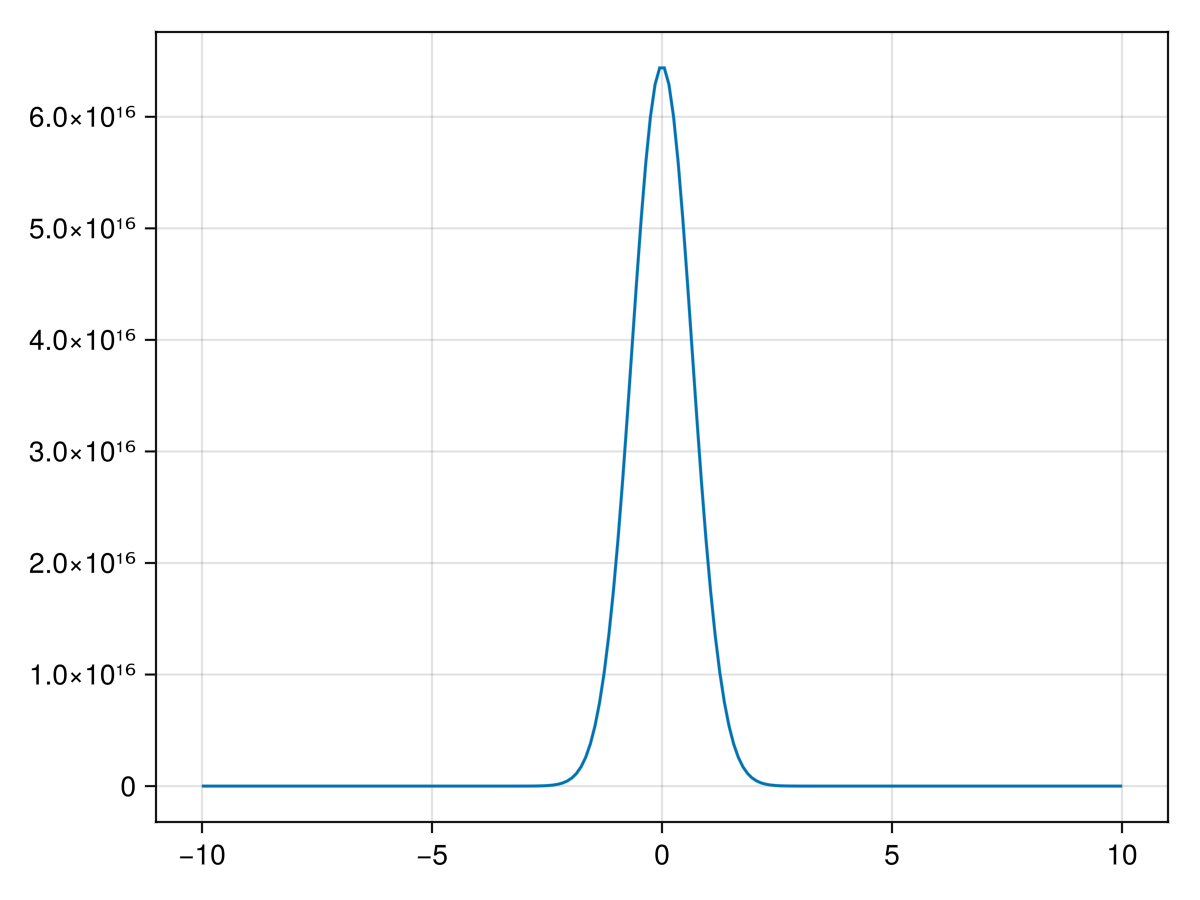

In [8]:

ρ = [sum(abs2, sol[end][4(j-1)+1 : 4(j-1)+4]) for j in 1:N]

using GLMakie
lines(x, ρ)


This shows how the wavepacket moves/oscillates according to the Dirac equation.



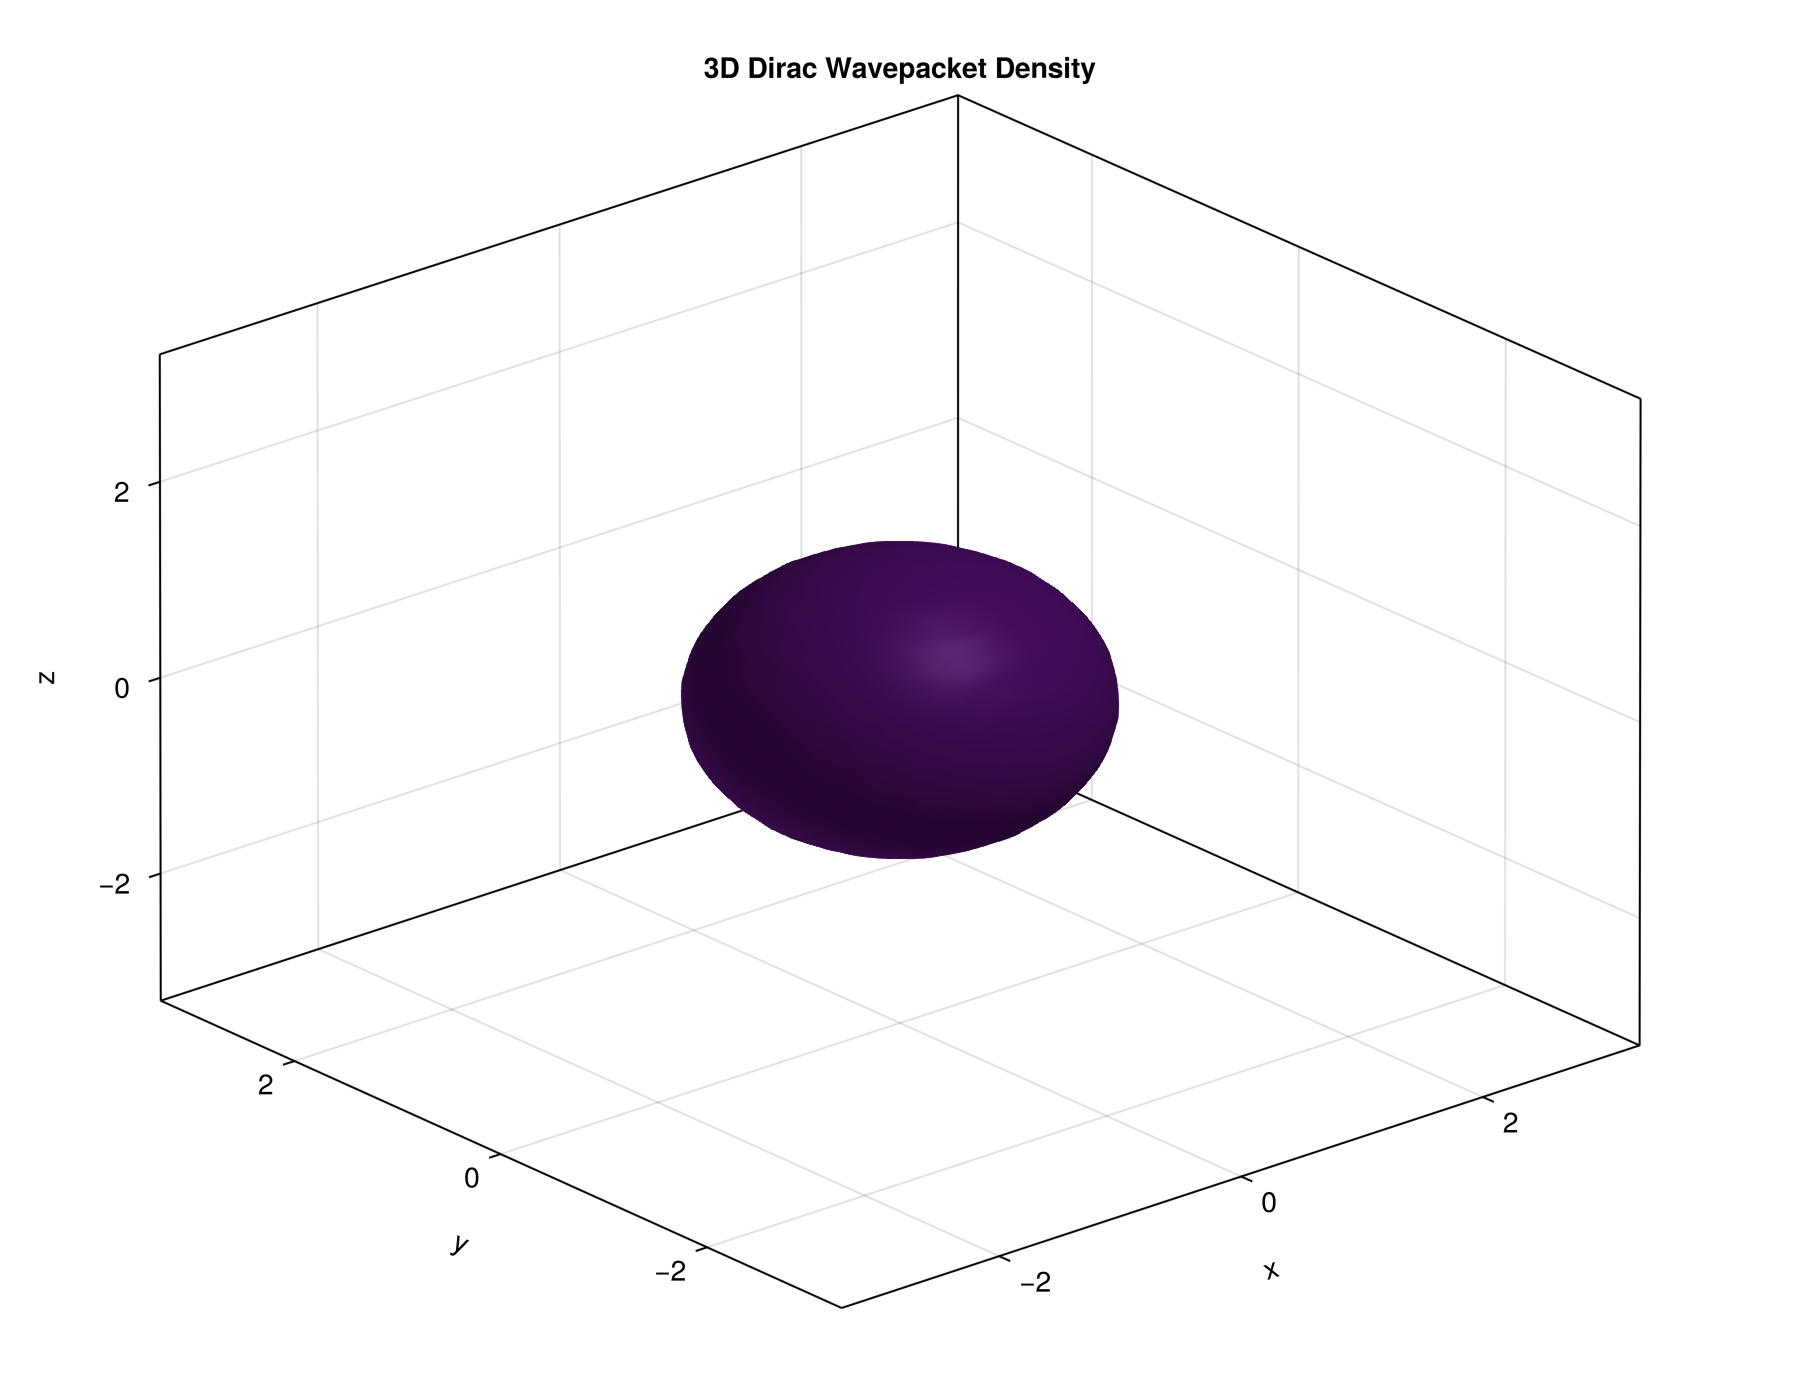

In [12]:
using LinearAlgebra
using DifferentialEquations
using GLMakie

# ------------------ Parameters ------------------
N = 30                # points per axis (coarse for demo)
L = 6.0               # spatial domain [-L/2, L/2]
dx = L / (N-1)
m = 1.0               # mass

# Dirac matrices (standard 4x4)
αx = [0 0 0 1;
      0 0 1 0;
      0 1 0 0;
      1 0 0 0]

αy = [0 0 0 -im;
      0 0 im 0;
      0 -im 0 0;
      im 0 0 0]

αz = [0 0 1 0;
      0 0 0 -1;
      1 0 0 0;
      0 -1 0 0]

β  = [1 0 0 0;
      0 1 0 0;
      0 0 -1 0;
      0 0 0 -1]

# ------------------ Spatial grid ------------------
x = range(-L/2, L/2, length=N)

# ------------------ Initial Gaussian spinor ------------------
function psi0(ix,iy,iz)
    X = x[ix]; Y = x[iy]; Z = x[iz]
    A = exp(-(X^2 + Y^2 + Z^2))
    return ComplexF64[A, 0, 0, 0]   # spin-up Gaussian
end

# Flatten 3D grid into 1D spinor array (length 4*N^3)
ψ_init = zeros(ComplexF64, 4*N^3)
for ix in 1:N, iy in 1:N, iz in 1:N
    idx = ((ix-1)*N + (iy-1))*N + iz
    ψ_init[4*(idx-1)+1:4*idx] .= psi0(ix,iy,iz)
end

# ------------------ Dirac ODE function ------------------
function dirac_ode!(dψ, ψ, p, t)
    @inbounds for ix in 2:N-1, iy in 2:N-1, iz in 2:N-1
        idx = ((ix-1)*N + (iy-1))*N + iz
        idrange = 4*(idx-1)+1:4*idx
        
        # neighbor indices
        idx_xp = ((ix+1-1)*N + (iy-1))*N + iz
        idx_xm = ((ix-1-1)*N + (iy-1))*N + iz
        idx_yp = ((ix-1)*N + (iy+1-1))*N + iz
        idx_ym = ((ix-1)*N + (iy-1-1))*N + iz
        idx_zp = ((ix-1)*N + (iy-1))*N + (iz+1)
        idx_zm = ((ix-1)*N + (iy-1))*N + (iz-1)
        
        # finite differences
        ψx = (ψ[4*(idx_xp-1)+1:4*idx_xp] - ψ[4*(idx_xm-1)+1:4*idx_xm])/(2dx)
        ψy = (ψ[4*(idx_yp-1)+1:4*idx_yp] - ψ[4*(idx_ym-1)+1:4*idx_ym])/(2dx)
        ψz = (ψ[4*(idx_zp-1)+1:4*idx_zp] - ψ[4*(idx_zm-1)+1:4*idx_zm])/(2dx)
        ψc = ψ[idrange]
        
        dψ[idrange] .= -im*(αx*ψx + αy*ψy + αz*ψz + β*m*ψc)
    end
    
    # zero derivative at boundaries
    dψ[1:4] .= 0
    dψ[end-3:end] .= 0
end

# ------------------ Solve ODE ------------------
prob = ODEProblem(dirac_ode!, ψ_init, (0.0, 0.5))  # short time for demo
sol = solve(prob, Tsit5(); saveat=0.1)

# ------------------ Compute probability density ρ(x,y,z) ------------------
ρ = zeros(N,N,N)
ψt = sol[end]  # last time step

for ix in 1:N, iy in 1:N, iz in 1:N
    idx = ((ix-1)*N + (iy-1))*N + iz
    ρ[ix,iy,iz] = sum(abs2, ψt[4*(idx-1)+1:4*idx])
end

# ------------------ 3D Visualization (GLMakie 0.24+ syntax) ------------------
fig = Figure(size=(900,700))
ax = Axis3(fig[1,1], title="3D Dirac Wavepacket Density")

# Choose a single isosurface for demonstration
volume!(ax, (-L/2,L/2), (-L/2,L/2), (-L/2,L/2), ρ;
        algorithm=:iso,
        isovalue=0.1)  # tweak to see the wavepacket clearly

fig
